In [1]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates


In [2]:
# load the data
DF = pd.read_csv("NormalisedReturnsSector.csv", index_col = "Date")
#DF = pd.read_csv("Companies1992_2012.csv",
#                index_col="Date")

In [3]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
DF

(5292, 11)


,Utilities,Information Technology,Materials,Health Care,Industrials,Consumer Discretionary,Financials,Communication Services,Consumer Staples,Real Estate,Energy
Date,,,,,,,,,,,
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-13.150235,-15.559262,3.114686,-10.961609,-20.927487,1.176756,-17.361941,-0.710343,-5.359795,1.153713,-14.043977
2012-12-26,-30.880331,-26.606141,-3.296699,-34.500741,-29.367562,-23.170483,-19.964943,-3.401398,-24.458479,-8.267458,-9.148394
2012-12-27,-4.516366,-7.459821,-9.782953,-0.294040,-12.563549,11.888090,-21.559166,-2.265019,1.924305,2.321190,-2.794459


In [4]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(11, 11)
55.0
(1, 121) 55
1


(5252, 55)

In [5]:
# Repeated KMeans into 2 clusters

In [6]:
kmean = KMeans(n_clusters = 2,random_state = 12345).fit(CorrMatrices) 


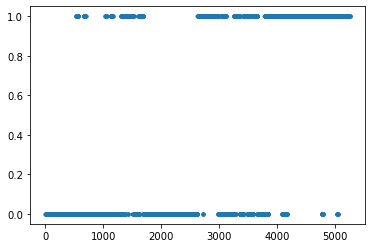

In [7]:
ypred = kmean.predict(CorrMatrices)

plt.plot(ypred,".")

In [8]:
#  now split the initial clusters

CMS0 = CorrMatrices[ypred ==0,:]
CMS1 = CorrMatrices[ypred ==1,:]
print(CMS0.shape,CMS1.shape)

(2857, 55) (2395, 55)


In [9]:
kmean0 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS0) 
ypred0 = kmean0.predict(CMS0)

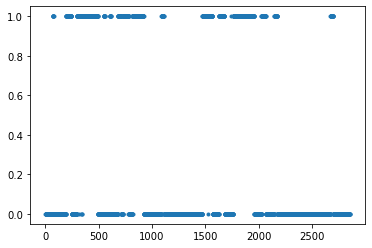

In [10]:
plt.plot(ypred0,".")

In [11]:
#  now split the these sub-clusters
CMS00 = CMS0[ypred0==0,:]
CMS01 = CMS0[ypred0==1,:]
print(CMS00.shape,CMS01.shape)

(1934, 55) (923, 55)


In [12]:
kmean00 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS00) 
ypred00 = kmean00.predict(CMS00)

In [13]:
kmean01 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS01) 
ypred01 = kmean01.predict(CMS01)

In [14]:
# final splits for the first initial cluster
CMS000 = CMS00[ypred00==0,:]
CMS001 = CMS00[ypred00==1,:]
CMS010 = CMS01[ypred01==0,:]
CMS011 = CMS01[ypred01==1,:]
print(CMS000.shape,
     CMS001.shape,
     CMS010.shape,
     CMS011.shape)

(1115, 55) (819, 55) (258, 55) (665, 55)


In [15]:
# Now for the second initial cluster

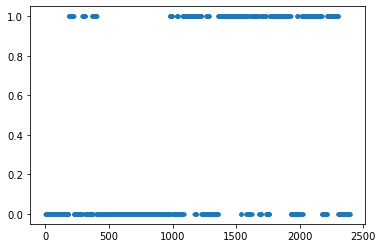

In [16]:
kmean1 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS1) 
ypred1 = kmean1.predict(CMS1)
plt.plot(ypred1,".")

In [17]:
#  now split the these sub-clusters
CMS10 = CMS1[ypred1==0,:]
CMS11 = CMS1[ypred1==1,:]
print(CMS10.shape,CMS11.shape)

(1376, 55) (1019, 55)


In [18]:
kmean10 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS10) 
ypred10 = kmean10.predict(CMS10)
kmean11 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS11) 
ypred11 = kmean11.predict(CMS11)

In [19]:
# final splits for the first initial cluster
CMS100 = CMS10[ypred10==0,:]
CMS101 = CMS10[ypred10==1,:]
CMS110 = CMS11[ypred11==0,:]
CMS111 = CMS11[ypred11==1,:]
print(CMS100.shape,
     CMS101.shape,
     CMS10.shape,
     CMS111.shape)

(955, 55) (421, 55) (1376, 55) (323, 55)


In [20]:
Labels = np.zeros(CorrMatrices.shape[0])

In [21]:
Lab = Labels[0:10]
print(Lab)
Lab  = np.arange(10)
print(Lab)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9]


In [22]:
print(Labels[0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
def Label(Instance):
    
    
    Label1 = kmean.predict(Instance.reshape(1, -1))

    if Label1 == 0:
    
        Label2 = kmean0.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean00.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean01.predict(Instance.reshape(1,-1))
    
    
    elif Label1 == 1:
    
        Label2 = kmean1.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean10.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean11.predict(Instance.reshape(1,-1))
    return(str(Label1[0])+str(Label2[0])+str(Label3[0]))
            

In [24]:
Labels = []
for i in range(CorrMatrices.shape[0]):
    Labels.append(Label(CorrMatrices[i,:]))

In [25]:
sum(np.array(Labels)== '101')

421

In [26]:
Labels = np.array(Labels)

In [27]:
Labels[Labels=="000"] = 0
Labels[Labels=="001"] = 1
Labels[Labels=="010"] = 2
Labels[Labels=="011"] = 3
Labels[Labels=="100"] = 4
Labels[Labels=="101"] = 5
Labels[Labels=="110"] = 6
Labels[Labels=="111"] = 7
Labels = Labels.astype(np.int)

In [28]:
TimeIndex = DF.index[20:(len(DF.index)-20)]

In [29]:
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

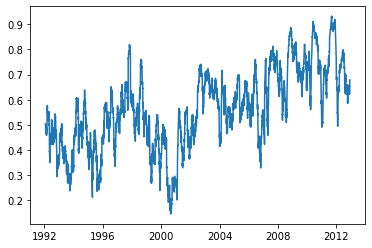

In [30]:
## Now get 1d Time Series

 # We look at the mean correlation value like Stepanov et al. and try to fit a time series to this.

c_bar = CorrMatrices.mean(axis=1)
plt.plot(T,c_bar)
plt.show()
TimeSeries = pd.DataFrame(data = {"t": T,
                                "c_bar": c_bar})
TimeSeries.to_csv("TimeSeries_Finance_Reduced")

In [31]:
print(len(T), len(Labels))

5252 5252


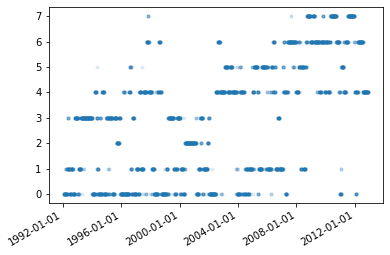

In [32]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,Labels, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [33]:
np.array(np.unique(Labels, return_counts=True)).T

array([[   0, 1115],
       [   1,  819],
       [   2,  258],
       [   3,  665],
       [   4,  955],
       [   5,  421],
       [   6,  696],
       [   7,  323]], dtype=int64)

In [34]:
# Combine all Centroids to one array

Centroids = np.concatenate((kmean00.cluster_centers_,
                            kmean01.cluster_centers_,
                            kmean10.cluster_centers_,
                           kmean11.cluster_centers_))
print(Centroids.shape)
print(Centroids[0].shape)

(8, 55)
(55,)


## Neuralising kmeans

In [35]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)

def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )


def DecisionLayer(Minimum):
    return(Minimum > 0)



def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [39]:
print("First instances Label is", Labels[0])

First instances Label is 0


In [46]:
k = 1451 # some instance

print("Should only be True for Label", Labels[k])

print(" # # # # # #")
for i in range(max(Labels)+1):
    print(i,DecisionLayer(NN_k(CorrMatrices[k,:],Centroids, i)))
    print("# # # # # ")
    
    

Should only be True for Label 6
 # # # # # #
0 False
# # # # # 
1 False
# # # # # 
2 False
# # # # # 
3 False
# # # # # 
4 False
# # # # # 
5 False
# # # # # 
6 True
# # # # # 
7 False
# # # # # 


In [60]:
layer2(layer1(CorrMatrices[0,:],Centroids,1),1)

-0.6504046851159071

In [61]:
nKM = max(Labels) + 1 # number of clusters


# CHeck for all instances
Layer_Pred = np.empty(CorrMatrices.shape[0])
Layer_1 = np.empty((CorrMatrices.shape[0], nKM))
Layer_2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],Centroids, j))    
        if Decision:
            Layer_Pred[i] = range(nKM)[j]
            Layer_1[i,:] = layer1(CorrMatrices[i,:], Centroids, j)
            Layer_2[i] = layer2(Layer_1[i,:], j)
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, Labels[i], Layer_Pred[i])
print(sum(Layer_Pred != Labels))


244


In [63]:
print(np.mean(Layer_2))
print(np.mean(Layer_2[Layer_Pred != Labels]))

0.5680203001494357
0.15598445820823437


#### Problem:

Neuralisation does not always yield the same results as the original clustering. The error quote is about 5%. The reason behind this (see above block) might be that the wrong labels have an output of layer2 that is close to zero, i.e. their classification  not as "clear-cut" 

In [56]:
Labels[Layer_Pred != Labels] 

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       4, 4, 0, 0, 0, 0, 0, 1, 0, 0, 4, 4, 4, 4, 0, 0, 1, 1, 0, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5,
       0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 1, 1, 1, 1, 6, 6, 6,
       6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [57]:
Layer_Pred[Layer_Pred != Labels]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 4., 3., 3., 3., 3.,
       5., 4., 4., 6., 6., 6., 6., 4., 4., 3., 3., 3., 0., 0., 0., 0., 0.,
       0., 0., 4., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 6., 6.,
       6., 6., 4., 4., 4., 4., 4., 6., 4., 4., 4., 4., 4., 6., 6., 6., 6.,
       4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 6.,
       6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 6.,
       6., 4., 4., 4., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6.